In [4]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms, utils

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook#jupyternotebookのプログレスバー表示
from pylab import rcParams

torch.backends.cudnn.benchmark = True #モデル高速化

ラベルサイズ: (441, 500)
ラベル(numpy)
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0  

   15  15  15  15  15  15  15  15  15  15  15  15  15 255]]
ラベル(Tensor)
 tensor([[[ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         [ 0,  0,  0,  ...,  0,  0,  0],
         ...,
         [ 0,  0,  0,  ..., 15, 15, 21],
         [ 0,  0,  0,  ..., 15, 15, 21],
         [ 0,  0,  0,  ..., 15, 15, 21]]])


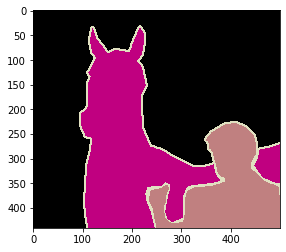

In [105]:
"""
np.set_printoptions(threshold=10000000)#numpyの表示上限変更
#ラベルの形式把握
image_path=r"C:\Users\kohei\Documents\Pytorch\Segmentation\2007_000799.png"#ラベル画像の絶対パス
img = Image.open(image_path)
plt.imshow(img)
print("ラベルサイズ:",np.array(img).shape)
print("ラベル(numpy)\n",np.array(img))
img=transforms.ToTensor()(img)#PIL -> Tensor, 正規化
img=make_mask(img)
print("ラベル(Tensor)\n",img)
"""

In [5]:
#壁画設定
%matplotlib inline
def show(img):
    npimg = img.numpy() #numpy配列に変換
    plt.grid(False) #グリッドをオフに
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")#BGR→RGB
    plt.show()

In [6]:
# 入力画像の変換
transform = transforms.Compose([
    transforms.CenterCrop(224), #中心の224×224をクロップ
    transforms.ToTensor(), #PIL -> Tensor, 正規化
    ])

def make_mask(tensor):
    tensor = (tensor*255).long() #int64型に変換 (CrossEntropyLossに渡すため)
    void = torch.full_like(tensor, 21, dtype=torch.int64)#([[21,21,21,...,21]
                                                         #        ....
                                                         # [21,21,21,...,21])
    tensor = torch.where(tensor==255, void, tensor) #tensor内の255(背景)を21に変換(クラス数)、if tensor==255 void else tensor
    return tensor.long()

# ラベル画像の変換
target_transform = transforms.Compose([
    transforms.CenterCrop(224), #中心の224×224をクロップ
    transforms.ToTensor(), #PIL -> Tensor, 正規化
    transforms.Lambda(lambda t: make_mask(t))#無名関数（画素数255を21に変換)
    ])

In [7]:
train_dataset = VOCSegmentation('./pascal-voc', 
                                                    year='2010', 
                                                    download=True, #ダウンロードしてない場合はTrue
                                                    image_set="train",
                                                    transform=transform,
                                                    target_transform=target_transform)
test_dataset = VOCSegmentation('./pascal-voc', 
                                                    year='2010', 
                                                    download=True, #ダウンロードしてない場合はTrue
                                                    image_set="val",
                                                    transform=transform,
                                                    target_transform=target_transform)

Using downloaded and verified file: ./pascal-voc\VOCtrainval_03-May-2010.tar


In [5]:
N = 4#バッチサイズ
train_loader = DataLoader(train_dataset, batch_size=N, 
                                        shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=N, 
                                       shuffle=False, drop_last=True)

入力画像サイズ： torch.Size([4, 3, 224, 224])
ラベル画像サイズ： torch.Size([4, 1, 224, 224])


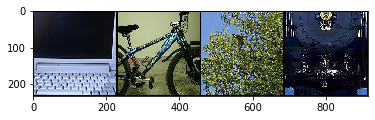

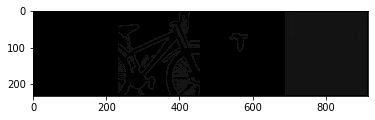

In [6]:
images, labels = iter(train_loader).next()
print("入力画像サイズ：",images.shape)
print("ラベル画像サイズ：",labels.shape)
show(utils.make_grid(images, padding=4))
show(utils.make_grid(labels, padding=4))

In [7]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.conv1 = self.conv(3, 64)
        self.conv2 = self.conv(64, 128)
        self.conv3 = self.conv(128, 256)
        self.conv4 = self.conv(256, 512)
        
        self.convm = self.conv(512, 1024)
        
        self.tconv4 = self.tconv(1024, 512)
        self.uconv4 = self.conv(1024, 512)
        self.tconv3 = self.tconv(512, 256)
        self.uconv3 = self.conv(512, 256)
        self.tconv2 = self.tconv(256, 128)
        self.uconv2 = self.conv(256, 128)
        self.tconv1 = self.tconv(128, 64)
        self.uconv1 = self.conv(128, 64)
        
        self.convo = nn.Conv2d(64, n_class, 1)
        
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.concat = self.Concat()

    def forward(self, input):
        # (3, 224, 224) -> (64, 112, 112)
        conv1 = self.conv1(input)
        pool1 = self.maxpool(conv1)
        pool1 = self.dropout(pool1)
        
        # (64, 112, 112) -> (128, 56, 56)
        conv2 = self.conv2(pool1)
        pool2 = self.maxpool(conv2)
        pool2 = self.dropout(pool2)
        
        # (128, 56, 56) -> (256, 28, 28)
        conv3 = self.conv3(pool2)
        pool3 = self.maxpool(conv3)
        pool3 = self.dropout(pool3)
        
        # (256, 28, 28) -> (512, 14, 14)
        conv4 = self.conv4(pool3)
        pool4 = self.maxpool(conv4)
        pool4 = self.dropout(pool4)
        
        # (512, 14, 14) -> (1024, 14, 14)
        convm = self.convm(pool4)
        
        # (1024, 14, 14) -> (512, 28, 28)
        tconv4 = self.tconv4(convm)
        uconv4 = self.concat(tconv4, conv4)
        uconv4 = self.uconv4(uconv4)
        uconv4 = self.dropout(uconv4)

        # (512, 28, 28) -> (256, 56, 56)
        tconv3 = self.tconv3(uconv4)
        uconv3 = self.concat(tconv3, conv3)
        uconv3 = self.uconv3(uconv3)
        uconv3 = self.dropout(uconv3)

        # (256, 56, 56) -> (128, 112, 112)
        tconv2 = self.tconv2(uconv3)
        uconv2 = self.concat(tconv2, conv2)
        uconv2 = self.uconv2(uconv2)
        uconv2 = self.dropout(uconv2)

        # (128, 112, 112) -> (64, 224, 224)
        tconv1 = self.tconv1(uconv2)
        uconv1 = self.concat(tconv1, conv1)
        uconv1 = self.uconv1(uconv1)
        uconv1 = self.dropout(uconv1)
        
        # (64, 224, 224) -> (22, 224, 224)
        output = self.convo(uconv1)
        
        return output
        
    def conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            )
    
    def tconv(self, in_channels, out_channels):
        return nn.Sequential(
            #転置畳み込み
            nn.ConvTranspose2d(in_channels, out_channels, 3, 
                                            padding=1, output_padding=1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            )
    #連結
    class Concat(nn.Module):
        def forward(self, x1, x2):
            return torch.cat([x1, x2], dim=1)

In [8]:
n_class = 22
unet = UNet(n_class)
unet.to("cuda:0")
from torchsummary import summary
summary(unet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
       BatchNorm2d-3         [-1, 64, 224, 224]             128
            Conv2d-4         [-1, 64, 224, 224]          36,928
              ReLU-5         [-1, 64, 224, 224]               0
       BatchNorm2d-6         [-1, 64, 224, 224]             128
         MaxPool2d-7         [-1, 64, 112, 112]               0
           Dropout-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
             ReLU-10        [-1, 128, 112, 112]               0
      BatchNorm2d-11        [-1, 128, 112, 112]             256
           Conv2d-12        [-1, 128, 112, 112]         147,584
             ReLU-13        [-1, 128, 112, 112]               0
      BatchNorm2d-14        [-1, 128, 1

In [114]:
#実際に車である、もしくはモデルが車であると予想した領域の内、モデルが正しく車であることを認識できた領域(TP)がどの程度か、を表したものになります。
def iou(label, pred, n_class, batch_size):
    iou_class = 0
    for i in range(n_class):
        intersection = ((label==i) & (pred==i)).float().sum(1) #TP"画像中に実際に存在する物体を、モデルが見つけることができた"sum(1)=列ごとに足す
        union = ((label==i) | (pred==i)).float().sum(1) #TP+FP+FN
        iou = ((intersection + 1e-6) / (union + 1e-6)) #IoU
        iou_class += iou.sum() / batch_size #バッチサイズ分の面積
    return iou_class / n_class

In [115]:
n_iter = 4#学習エポック
device = "cuda:0"
optimizer = optim.Adam(unet.parameters())
loss_fn = nn.CrossEntropyLoss(reduction="sum")#ソフトマックス込み(LogSoftmax)


unet.to(device)
for epoch in range(n_iter):
    #訓練
    unet.train()
    running_loss, trn_acc, trn_iou = 0, 0, 0
    for x_train, y_train in tqdm_notebook(train_loader):#x_train=画像データ、y_train=ラベル
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()#勾配の初期化

        y_out = unet(x_train)
        y_out = y_out.view(N, n_class, -1)#-1を指定した軸は、要素数を自動で調整してくれる。
        y_train = y_train.view(N, -1)
        loss = loss_fn(y_out, y_train)
        loss.backward()#自動微分
        optimizer.step()#勾配の更新
       # running_loss += loss.detach()
        running_loss += loss.item()#中身(Temsorの数値)を取り出す
        _, y_pred = y_out.max(1)#22個の画像の中で各ピクセルに対して画素値が最大のもののindexを取る
        trn_acc += (y_train == y_pred).float().sum().item() \
                         / (y_train.nelement()*len(train_loader)) #正解ピクセル数/全ピクセル数(ピクセル数＊バッチサイズ)
        trn_iou += iou(y_train, y_pred, n_class, N) / len(train_loader)
        
    #評価
    unet.eval()
    tst_iou = 0
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        with torch.no_grad(): #推論の計算だけなので自動微分に必要な処理off
            y_out = unet(x_test)
        y_out = y_out.view(N, n_class, -1)
        y_test = y_test.view(N, -1)
        _, y_pred = y_out.max(1)
        tst_iou += iou(y_test, y_pred, n_class, N) / len(test_loader)
        
    print(f"epoch: {epoch+1}| " \
            f"train loss: {running_loss:.1f}| " \
            f"train acc: {trn_acc:.5f}| " \
            f"train iou: {trn_iou:.5f}| " \
            f"test iou: {tst_iou:.5f}")


epoch: 1| train loss: 130526406.2| train acc: 0.41624| train iou: 0.06495| test iou: 0.80878



epoch: 2| train loss: 104732977.2| train acc: 0.51124| train iou: 0.41295| test iou: 0.83266



epoch: 3| train loss: 97872273.7| train acc: 0.51663| train iou: 0.54695| test iou: 0.86940



epoch: 4| train loss: 96321950.5| train acc: 0.51699| train iou: 0.53680| test iou: 0.85495


In [11]:
torch.save(unet.state_dict(),"unet.ckpt")#モデルの保存

In [9]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

torch.Size([1, 3, 224, 224])


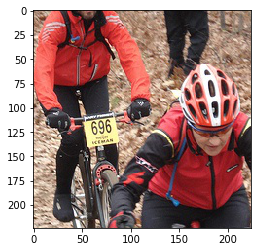

In [10]:
#予測デモ
image_path=r"C:\Users\kohei\Documents\Pytorch\2007_001630.jpg"#予測したい画像の絶対パス
img = Image.open(image_path)#'JpegImageFile' object
img = crop_center(img,224,224)
plt.imshow(img)
img=transforms.ToTensor()(img)#'JpegImageFile' object→Tensor、正規化
img=img.unsqueeze(0)#バッチの次元を追加
print(img.shape)

In [11]:
#学習済みモデルを使用する場合はモデルをロード
unet.load_state_dict(torch.load("unet.ckpt"))


<All keys matched successfully>

カラーインデックス
 [[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]]


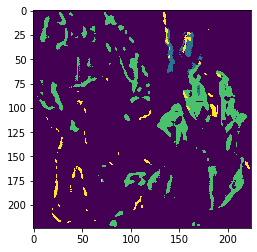

In [15]:
unet.eval()
with torch.no_grad():
    output_image=unet(img.cuda())#モデルに推測させる
    output_image=output_image.cpu()
    value,idx=torch.max(output_image,1)#22個の画像の中で各ピクセルに対して画素値が最大のものの値とindexを取る
    np.set_printoptions(threshold=10000000)#numpyの表示上限変更
    print("カラーインデックス\n",idx.numpy())
    plt.imshow(idx[0])

In [25]:
#中間出力
with torch.no_grad():
    #ブロック毎の中間出力を得ていく
     # (3, 224, 224) -> (64, 112, 112)
        conv1 = unet.conv1(img.cuda())
        pool1 = unet.maxpool(conv1)
        pool1 = unet.dropout(pool1)
        
        # (64, 112, 112) -> (128, 56, 56)
        conv2 = unet.conv2(pool1)
        pool2 = unet.maxpool(conv2)
        pool2 = unet.dropout(pool2)
        
        # (128, 56, 56) -> (256, 28, 28)
        conv3 = unet.conv3(pool2)
        pool3 = unet.maxpool(conv3)
        pool3 = unet.dropout(pool3)
        
        # (256, 28, 28) -> (512, 14, 14)
        conv4 = unet.conv4(pool3)
        pool4 = unet.maxpool(conv4)
        pool4 = unet.dropout(pool4)
        
        # (512, 14, 14) -> (1024, 14, 14)
        convm = unet.convm(pool4)
        
        # (1024, 14, 14) -> (512, 28, 28)
        tconv4 = unet.tconv4(convm)
        uconv4 = unet.concat(tconv4, conv4)
        uconv4 = unet.uconv4(uconv4)
        uconv4 = unet.dropout(uconv4)

        # (512, 28, 28) -> (256, 56, 56)
        tconv3 = unet.tconv3(uconv4)
        uconv3 = unet.concat(tconv3, conv3)
        uconv3 = unet.uconv3(uconv3)
        uconv3 = unet.dropout(uconv3)

        # (256, 56, 56) -> (128, 112, 112)
        tconv2 = unet.tconv2(uconv3)
        uconv2 = unet.concat(tconv2, conv2)
        uconv2 = unet.uconv2(uconv2)
        uconv2 = unet.dropout(uconv2)

        #cpuに移動
        conv2=conv2.cpu()
        conv3=conv3.cpu()
        conv4=conv4.cpu()
        uconv4=uconv4.cpu()
        uconv3=uconv3.cpu()
        uconv2=uconv2.cpu()

In [26]:
plt.gray()#グレースケールで表示(フィルタは1チャンネルで表示)
rcParams['figure.figsize'] = 10,10#10倍拡大

#指定したブロックの中間出力を壁画する関数
def output_image(output,block_num):
    output=output.numpy()
    for i in range(0,10):
        ax=plt.subplot(6,10,10*(block_num-1)+(i+1))#5*10個に領域分けしたうちの5*(ブロック数-11)*(i+1)個目を選択
        # 目盛りを無くす。
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(output[0][i])#出力

<Figure size 720x720 with 0 Axes>

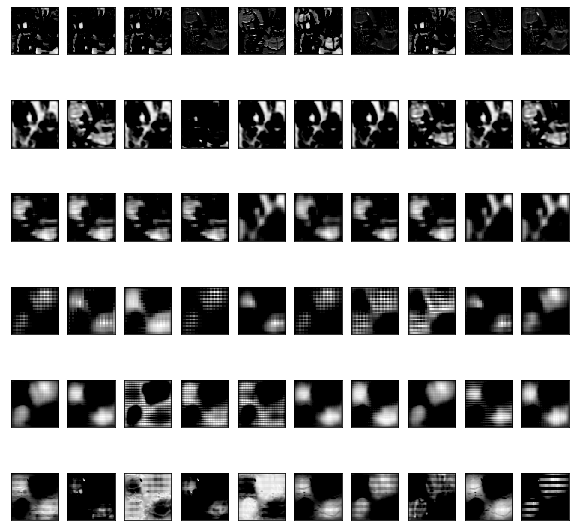

In [28]:
output_image(conv2,1)
output_image(conv3,2)
output_image(conv4,3)
output_image(uconv4,4)
output_image(uconv3,5)
output_image(uconv2,6)